# Data Cleaning

In [492]:
import pandas as pd
import numpy as np
import swifter
import re
import Levenshtein as lev
import random

from datetime import datetime as dt
from functools import reduce

import warnings
warnings.filterwarnings("ignore")

In [493]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [494]:
data = pd.read_csv("gun-violence-data_01-2013_03-2018.csv")

In [495]:
data.head(3)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,congressional_district,gun_stolen,gun_type,incident_characteristics,latitude,location_description,longitude,n_guns_involved,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,14.0,NaN,NaN,Shot - Wounded/Injured||Mass Shooting (4+ vict...,40.3467,NaN,-79.8559,NaN,Julian Sims under investigation: Four Shot and...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,43.0,NaN,NaN,"Shot - Wounded/Injured||Shot - Dead (murder, a...",33.9090,NaN,-118.3330,NaN,Four Shot; One Killed; Unidentified shooter in...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,9.0,0::Unknown||1::Unknown,0::Unknown||1::Unknown,"Shot - Wounded/Injured||Shot - Dead (murder, a...",41.4455,Cotton Club,-82.1377,2.0,NaN,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0


In [496]:
data.describe()

,incident_id,n_killed,n_injured,congressional_district,latitude,longitude,n_guns_involved,state_house_district,state_senate_district
count,2.396770e+05,239677.000000,239677.000000,227733.000000,231754.000000,231754.000000,140226.000000,200905.000000,207342.00000
mean,5.593343e+05,0.252290,0.494007,8.001265,37.546598,-89.338348,1.372442,55.447132,20.47711
std,2.931287e+05,0.521779,0.729952,8.480835,5.130763,14.359546,4.678202,42.048117,14.20456
min,9.211400e+04,0.000000,0.000000,0.000000,19.111400,-171.429000,1.000000,1.000000,1.00000
25%,3.085450e+05,0.000000,0.000000,2.000000,33.903400,-94.158725,1.000000,21.000000,9.00000
50%,5.435870e+05,0.000000,0.000000,5.000000,38.570600,-86.249600,1.000000,47.000000,19.00000
75%,8.172280e+05,0.000000,1.000000,10.000000,41.437375,-80.048625,1.000000,84.000000,30.00000
max,1.083472e+06,50.000000,53.000000,53.000000,71.336800,97.433100,400.000000,901.000000,94.00000


In [497]:
def missing_values_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (round(df.isnull().sum() / df.isnull().count() * 100, 2)).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data['Total'] = missing_data['Total'].map('{:,.0f}'.format)
    return missing_data.T

In [498]:
missing_values_table(data)

,participant_relationship,location_description,participant_name,gun_stolen,gun_type,n_guns_involved,participant_age,notes,participant_age_group,state_house_district,participant_gender,state_senate_district,participant_status,participant_type,address,congressional_district,latitude,longitude,sources,source_url,incident_characteristics,incident_url_fields_missing,incident_url,n_injured,n_killed,city_or_county,state,date,incident_id
Total,"223,903","197,588","122,253","99,498","99,451","99,451","92,298","81,017","42,119","38,772","36,362","32,335","27,626","24,863","16,497","11,944","7,923","7,923",609,468,326,0,0,0,0,0,0,0,0
Percent,93.42,82.44,51.01,41.51,41.49,41.49,38.51,33.8,17.57,16.18,15.17,13.49,11.53,10.37,6.88,4.98,3.31,3.31,0.25,0.2,0.14,0,0,0,0,0,0,0,0


In [499]:
def unique_values_table(df):
    total = df.nunique().sort_values(ascending=False)
    percent = (round(df.nunique() / df.count() * 100, 2)).sort_values(ascending=False)
    unique_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    unique_data['Total'] = unique_data['Total'].map('{:,.0f}'.format)
    return unique_data.T

In [500]:
unique_values_table(data)

,address,city_or_county,congressional_district,date,gun_stolen,gun_type,incident_characteristics,incident_id,incident_url,incident_url_fields_missing,latitude,location_description,longitude,n_guns_involved,n_injured,n_killed,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,source_url,sources,state,state_house_district,state_senate_district
Total,"198,037","12,898",54,"1,725",349,"2,502","18,126","239,677","239,677",1,"101,240","27,595","112,347",106,23,16,"136,652","18,951",898,873,"113,488",284,"2,150",259,"213,989","217,280",51,275,68
Percent,88.73,5.38,0.02,0.72,0.25,1.78,7.57,100,100,0,43.68,65.56,48.48,0.08,0.01,0.01,86.13,12.86,0.45,0.43,96.65,1.8,1.01,0.12,89.46,90.89,0.02,0.14,0.03


In [501]:
# types
# skewness
# correlations: pearson's r, spearman's p, kendall's t, phik, cramer's v

In [502]:
# Add the Las Vegas shooting incident from 2017
lv_incident = pd.read_csv("las-vegas-1-10-2017.csv")
data = pd.concat([data, lv_incident])

In [503]:
# Index incidents using Incident ID
data.set_index("incident_id", inplace=True)

In [504]:
# Delete columns that are irrelevant to the analysis
data = data.drop(["incident_url_fields_missing", "incident_url", "source_url", "sources"], axis=1)

In [505]:
# Convert dates to datetime objects
data["date"] = pd.to_datetime(data["date"])

# Reorder newly created dataframe
data = data.sort_values(by=["date"])

In [506]:
# Rearrange the columns for readibility
data = data[['date', 'state', 'city_or_county', 'address', 'location_description', 'n_killed', 'n_injured', 
             'incident_characteristics', 'n_guns_involved', 'gun_stolen', 'gun_type', 'notes', 
             'participant_name', 'participant_age', 'participant_age_group', 'participant_gender', 
             'participant_status', 'participant_type', 'participant_relationship']]

In [508]:
data[["suspect_name", "suspect_age", "suspect_age_group", "suspect_gender", "suspect_status", "n_suspects"]] = pd.DataFrame([[np.nan for _ in range(6)] for _ in range(data.shape[0])], index=data.index)

In [509]:
# Function to split a dictionary string into a Python dictinary
def split_into_str_dict(string):
    if pd.isnull(string):
        return np.nan
    str_dict = dict()
    # Split the string by '|' or '||', depending on the format
    list = '#$%'.join('#$%'.join(string.split('||')).split('|')).split('#$%')
    for index in list:
        # If indices and values are split by '::'
        i, sep, v = index.partition('::')
        if sep and v:
            str_dict[int(i)] = v
        # If indices and values are split by ':'
        else:
            i, _, v = index.partition(':')
            str_dict[int(i)] = v
    return str_dict

In [510]:
# Function to convert a dictionary's values to int
def convert_dict_to_int(str_dict):
    if pd.isnull(str_dict):
        return np.nan
    for key in str_dict:
        str_dict[key] = int(str_dict[key])
    return str_dict

In [511]:
# Function to split a list string into a Python list
def split_into_list(string):
    if pd.isnull(string):
        return np.nan
    # Split the string by '|' or '||', depending on the format
    return '#$%'.join('#$%'.join(string.split('||')).split('|')).split('#$%')

In [512]:
def populate_suspect_columns(key, row):
    offset = data.columns.get_loc("suspect_name") - data.columns.get_loc("participant_name")
    for col in range(data.columns.get_loc("participant_name"), data.columns.get_loc("participant_status")+1):
        if pd.notnull(row[col]):
            if key in row[col].keys():
                if pd.isnull(row[col+offset]):
                    row[col+offset] = dict()
                row[col+offset][key] = row[col][key]
                del row[col][key]
            if len(row[col]) == 0:
                row[col] = np.nan

In [513]:
def find_suspect_key(row):
    nr_suspects = 0
    if pd.notnull(row[data.columns.get_loc("participant_type")]):
        for k, v in row[data.columns.get_loc("participant_type")].items():
            if v == "Subject-Suspect":
                nr_suspects += 1
                populate_suspect_columns(k, row)
    row[data.columns.get_loc("n_suspects")] = nr_suspects
    return row

In [514]:
def clean(d_list, index, columns):
    return pd.DataFrame([find_suspect_key(d_list[i]) for i in range(d_list.shape[0])], index=index, columns=columns)

In [515]:
for col in ['gun_stolen', 'gun_type', 'participant_name', 'participant_age', 'participant_age_group', 'participant_gender', 'participant_relationship', 'participant_status', 'participant_type']:
    data[col] = data[col].apply(split_into_str_dict)
data['participant_age'] = data['participant_age'].apply(convert_dict_to_int)
data['incident_characteristics'] = data['incident_characteristics'].apply(split_into_list)

In [516]:
data_list = data.values
data = clean(data_list, data.index, data.columns)

In [517]:
def replace_dict(dictionary):
    if pd.notnull(dictionary):
        return len(dictionary)
    else:
        return np.nan
    
data["participant_type"] = data["participant_type"].apply(lambda x: replace_dict(x))
data.rename(columns = {"participant_type": "n_victims"}, inplace = True)
data.rename(columns = {"participant_relationshiop": "victim_suspect_relationship"}, inplace = True)

In [518]:
for suffix in ["name", "age", "age_group", "gender", "relationship", "status"]:
    data.rename(columns = {"participant_" + suffix: "victim_" + suffix}, inplace = True)

In [463]:
# Lookup dictionary of common address abbreviations found in the dataset
lookup_dict = {"Pkwy": "Parkway", "Blvd": " Boulevard", "Rd": "Road", "Dr ": "Drive ",
               "Dr$": "Drive", "Ave ": "Avenue ", "Ave$": "Avenue", "avenues": "Avenues",
               "Block": "block", "Expwy": "Expressway", "Pl ": "Place ", "Pl$": "Place", 
               "Ln": "Lane", "Northwest": "NW", "Southwest": "SW", "Northeast": "NE",
               "Southeast": "SE", "North-west": "NW", "South-west": "SW", "North-east": "NE",
               "South-east": "SE", "NorthWest": "NW", "SouthWest": "SW", "NorthEast": "NE",
               "SouthEast": "SE", "North-West": "NW", "South-West": "SW", "North-East": "NE",
               "South-East": "SE", "North ": "N ", "South ": "S ", "East ": "E ", "West ": "W ",
               "North$": "N", "South$": "S", "East$": "E", "West$": "W", "Av ": "Avenue ", 
               "Av$": "Avenue", "St$": "Street"}

In [348]:
# Function to format white spaces neatly in an address string
def clean_whitespaces(address):
    # Remove double spaces
    new_address = re.sub(' +', ' ', address)
    # Remove spaces before comma
    new_address = re.sub(' ,', ',', new_address)
    # Revove spaces at the beginning and end of an address
    new_address = re.sub(r'^\s+', '', new_address, flags=re.UNICODE)
    new_address = re.sub(r"\s+$", "", new_address, flags=re.UNICODE)
    return new_address

In [349]:
# Function to remove special characters such as dashes (-), commas (,), or slashes (/) from an address string
def clean_special_characters(address):
    # Remove periods
    new_address = re.sub("\.", "", address)
    # Remove commas, dashes, slashes
    new_address = re.sub(",|\-|\/", " ", new_address)
    return new_address

In [350]:
# Function to format strings and apply lookup_dict rules
def clean_address_string(address):
    if pd.isnull(address):
        return np.nan
    else:
        new_address = clean_special_characters(address)
        # Apply lookup_dict rules
        new_address = reduce(lambda x, y: re.sub(y, lookup_dict[y], x), lookup_dict, new_address)
        new_address = clean_whitespaces(new_address)
        return new_address

In [80]:
# Function to remove house/street numbers from address
def clean_unique_address(address):
    # Remove orders
    address = re.sub('([0-9]*th|[0-9]*1st|[0-9]*2nd|[0-9]*3rd)', ' ', address)
    # Remove digits
    address = re.sub('[0-9]*', '', address)
    # Remove cardinal points
    address = re.sub('N |E |S |W |NE|NW|SE|SW', ' ', address)
    # Clean whitespaces
    address = clean_whitespaces(address)
    return address

In [81]:
# Compare addresses only after removing numbers to ensure that the dissimilarity is not caused by houses/streets of different numbers
lev_addresses = dict()
for item in list(set(data[pd.notnull(data['Address'])]["Address"].apply(clean_address_string))):
    lev_addresses[index] = clean_unique_address(item)
    index += 1

In [83]:
# Sample 1% of the addresses
lev_addresses = dict(random.sample(lev_addresses.items(), 1884))

In [443]:
# Find combinations of addresses that have between 0.95 and 0.99 similarity, disregarding numbers of streets and cardinals
for sampled_address in sample_lev_addresses.keys():
    for address in unique_addresses.keys():
        similarity = lev.ratio(lev_addresses[sampled_address], lev_addresses[address])
        if similarity*100 in range(95, 100):
            print("There is a similarity of " + str(similarity) + " between the following strings:")
            print(" 1. " + unique_addresses[sampled_address])
            print(" 2. " + unique_addresses[address])

There is a similarity of 0.95 between the following strings:
 1. 1800 block of Amber Drive
 2. 3000 block of Ember Drive
There is a similarity of 0.96 between the following strings:
 1. N Clark Street
 2. 1812 W Clarke Street
There is a similarity of 0.96 between the following strings:
 1. N Clark Street
 2. 1820 W Clarke Street
There is a similarity of 0.96 between the following strings:
 1. N Clark Street
 2. Clarke Street
There is a similarity of 0.96 between the following strings:
 1. N Clark Street
 2. 1617 W Clarke Street
There is a similarity of 0.96 between the following strings:
 1. N Clark Street
 2. 3900 Clarke Street
There is a similarity of 0.95 between the following strings:
 1. 1000 block of Eagle Drive
 2. 1950 block of Cagle Drive
There is a similarity of 0.96 between the following strings:
 1. 202 W Baker Street
 2. 185 Barker Street
There is a similarity of 0.96 between the following strings:
 1. 202 W Baker Street
 2. 75 Barker Street
There is a similarity of 0.96 b

There is a similarity of 0.96 between the following strings:
 1. 304 Waters Avenue
 2. S Water Avenue
There is a similarity of 0.96 between the following strings:
 1. 304 Waters Avenue
 2. Water Avenue
There is a similarity of 0.96 between the following strings:
 1. 304 Waters Avenue
 2. NW Water Avenue
There is a similarity of 0.96 between the following strings:
 1. 6400 block of S Claremont Avenue
 2. 2900 block of Clairmont Avenue
There is a similarity of 0.95 between the following strings:
 1. 2200 block of Poland Road
 2. 8300 block of Noland Road
There is a similarity of 0.95 between the following strings:
 1. 2200 block of Poland Road
 2. 9700 block of Noland Road
There is a similarity of 0.95 between the following strings:
 1. 2200 block of Poland Road
 2. 1100 block of N Noland Road
There is a similarity of 0.95 between the following strings:
 1. 1100 block of Oster Drive
 2. 100 block of Otero Drive
There is a similarity of 0.95 between the following strings:
 1. 1100 block o

There is a similarity of 0.96 between the following strings:
 1. 800 block of Martin Luther King Boulevard
 2. 300 block of Martin Luther King Jr Boulevard
There is a similarity of 0.96 between the following strings:
 1. 800 block of Martin Luther King Boulevard
 2. 2600 block of Martin Luther King Jr Boulevard SW
There is a similarity of 0.96 between the following strings:
 1. 800 block of Martin Luther King Boulevard
 2. 100 block of Martin Luther King Jr Boulevard
There is a similarity of 0.96 between the following strings:
 1. 800 block of Martin Luther King Boulevard
 2. 300 block of N Martin Luther King Jr Boulevard
There is a similarity of 0.96 between the following strings:
 1. 800 block of Martin Luther King Boulevard
 2. 800 block of S Martin Luther King Jr Boulevard
There is a similarity of 0.96 between the following strings:
 1. 800 block of Martin Luther King Boulevard
 2. 600 block of Martin Luther King Jr Boulevard
There is a similarity of 0.96 between the following stri

There is a similarity of 0.95 between the following strings:
 1. 1700 block of Eden Avenue
 2. 10300 block of Edes Avenue
There is a similarity of 0.95 between the following strings:
 1. 1700 block of Eden Avenue
 2. 8400 block of Edes Avenue
There is a similarity of 0.95 between the following strings:
 1. 1700 block of Eden Avenue
 2. 2300 block of Edna Avenue
There is a similarity of 0.95 between the following strings:
 1. 1700 block of Eden Avenue
 2. 5900 block of Edna Avenue
There is a similarity of 0.95 between the following strings:
 1. 1700 block of Eden Avenue
 2. 9800 block of Edes Avenue
There is a similarity of 0.95 between the following strings:
 1. 1700 block of Eden Avenue
 2. 10400 block of Edes Avenue
There is a similarity of 0.96 between the following strings:
 1. 615 N Hawley Street
 2. Haley Street
There is a similarity of 0.96 between the following strings:
 1. 512 S Kings Highway
 2. 5937 King Highway
There is a similarity of 0.96 between the following strings:
 1

There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 3100 block of High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 200 block of High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 1700 block of High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 10000 block of High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 400 block of High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 3400 block of High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 1100 block of E High Street
There is a similarity of 0.95 between the following strings:
 1. 2600 block of Eighth Street NE
 2. 900 block of High

There is a similarity of 0.96 between the following strings:
 1. 6422 Storer Avenue
 2. 92 Store Avenue
There is a similarity of 0.95 between the following strings:
 1. 1800 block of Pryor Street
 2. 4200 block of Pro Street
There is a similarity of 0.95 between the following strings:
 1. 1500 block of SW Polk Street
 2. 300 block of Folk Street
There is a similarity of 0.96 between the following strings:
 1. Cricket Lane
 2. 20 Crickett Lane
There is a similarity of 0.96 between the following strings:
 1. Elliot Street
 2. 36 Eliot Street
There is a similarity of 0.95 between the following strings:
 1. 500 block of Iowa Avenue
 2. 3200 block of Iola Avenue
There is a similarity of 0.96 between the following strings:
 1. 1214 Baker Avenue
 2. 4969 N Backer Avenue
There is a similarity of 0.96 between the following strings:
 1. 1214 Baker Avenue
 2. N Backer Avenue
There is a similarity of 0.96 between the following strings:
 1. 1214 Baker Avenue
 2. 273 Barker Avenue
There is a similar

In [351]:
# TODO optimize this
data['address'] = data['address'].apply(clean_address_string)

In [586]:
print("Total number of incidents recorded in 2013: \t"+ str(len(data[data["date"].dt.year == 2013])))
print("Average number of incidents recorded (2014-17): " + str(round(len(data[data["date"].dt.year.between(2014, 2018)]) / 4)))

Total number of incidents recorded in 2013: 	278
Total number of incidents recorded in 2014: 	51854
Total number of incidents recorded in 2015: 	53579
Total number of incidents recorded in 2016: 	58763
Total number of incidents recorded in 2017: 	61402
Total number of incidents recorded in 2018: 	13802
-------------------------------------------------------
Total number of incidents recorded: 		239678
-------------------------------------------------------
Average number of incidents recorded (2014-17): 59850


In [587]:
def get_yearly_casualties(row):
    return max(row[data.columns.get_loc("n_killed")] + row[data.columns.get_loc("n_injured")] - row[data.columns.get_loc("n_uspects")], 0)

In [588]:
def yearly_casualties(data, year):
    return [get_yearly_casualties(data[i]) for i in range(data.shape[0]) if data[i][0].year == 2013]

In [589]:
casualties_2013 = yearly_casualties(data.values, 2013)

In [590]:
print("Total number of mass shootings in 2013: " + str(len([nr_casualties for nr_casualties in casualties_2013 if nr_casualties >= 4])))
print("Total number of incidents in 2013: \t" + str(len(casualties_2013)))

Total number of mass shootings in 2013: 151
Total number of incidents in 2013: 	278


In [591]:
# Create a mass shooting dataset for further analysis
mass_shootings = data[(data["Nr Killed"] + data["Nr Injured"] - data["Nr Suspects"]) >= 4]

# Remove 2013 incidents from the dataset
data = data[data["Date"].dt.year != 2013]

# Data Visualisation

## Date

In [592]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from dateutil import rrule
import calendar
import collections
from collections import Counter
from datetime import timedelta as td

mpl.style.use('default')

In [593]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
          'October', 'November', 'December']
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
holidays = {"New Year's Day": dt(2000, 1, 1), "Martin Luther King, Jr. Day": dt(2000, 1, 21), 
            "George Washington’s Birthday": dt(2000, 2, 18), "Memorial Day": dt(2000, 5, 27),
            "Independence Day": dt(2000, 7, 4), "Labor Day": dt(2000, 9, 2), "Columbus Day": dt(2000, 10, 14),
            "Veterans Day": dt(2000, 11, 11), "Thanksgiving Day": dt(2000, 11, 28), "Christmas Day": dt(2000, 12, 25)}

In [594]:
casualties_by_year = dict()
incidents_by_year = dict()

for year in range(2014, 2019):
    casualties_by_year[year] = sum([row[data.columns.get_loc("Nr Killed")] + row[data.columns.get_loc("Nr Injured")] for row in data[data["Date"].dt.year == year].values])
    incidents_by_year[year] = len([row[data.columns.get_loc("Nr Killed")] + row[data.columns.get_loc("Nr Injured")] for row in data[data["Date"].dt.year == year].values]) 

In [595]:
incidents_by_month = dict()
for year in range(2014, 2019):
    incidents_by_month[year] = dict()

# Initialise dictionary with 0's
for date in rrule.rrule(rrule.MONTHLY, dtstart=dt(2014, 1, 1), until=dt(2018, 3, 1)):
    incidents_by_month[date.year][date.month] = 0
    
# Populate dictionary
for year in range(2014, 2019):
    for month in range (1, 13):
        incidents_by_month[year][month] = len([x for x in data[(data["Date"].dt.year == year) & (data["Date"].dt.month == month)].values]) 

In [596]:
# Divide number of incidents for each month by the number of days
for date in rrule.rrule(rrule.MONTHLY, dtstart=dt(2014, 1, 1), until=dt(2018, 3, 1)):
    incidents_by_month[date.year][date.month] = round(incidents_by_month[date.year][date.month] / calendar.monthrange(date.year, date.month)[1], 2)

In [597]:
# Invert dictionary, to set months as primary keys
inverted = collections.defaultdict(dict)
for key, subdict in incidents_by_month.items():
    for k, v in subdict.items():
        inverted[k][key] = v

In [598]:
# Average the values over all years
incidents_by_month_2 = {}
for k, subdict in inverted.items():
    incidents_by_month_2[k] = round(sum(subdict.values()) / float(len([x for x in subdict.values() if x is not 0])), 2)

In [599]:
incidents_by_date = dict()
incidents_by_date_mean = dict()

# Initialise dictionary with 0's
sd = dt.strptime('2014-01-01','%Y-%m-%d')
ed = dt.strptime('2018-03-31','%Y-%m-%d')
delta = ed - sd
for i in range(delta.days+1):
    incidents_by_date[sd + td(days = i)] = 0
    
sd = dt.strptime('2000-01-01','%Y-%m-%d')
ed = dt.strptime('2000-12-31','%Y-%m-%d')
delta = ed - sd
for i in range(delta.days+1):
    incidents_by_date_mean[sd + td(days = i)] = 0
    
# Populate dictionary
for row in data.values:
    incidents_by_date[dt(row[data.columns.get_loc("Date")].year, row[data.columns.get_loc("Date")].month, row[data.columns.get_loc("Date")].day)] += 1
    incidents_by_date_mean[dt(2000, row[data.columns.get_loc("Date")].month, row[data.columns.get_loc("Date")].day)] += 1

In [600]:
for key in incidents_by_date_mean.keys():
    if key.month in range(1, 4):
        if (key.month == 2) and (key.day == 29):
            pass
        else:
            incidents_by_date_mean[key] /= 5
    else:
        incidents_by_date_mean[key] /= 4

In [601]:
incidents_by_weekday = dict()
nr_weekdays = dict()

for weekday in range(0, 7):
    incidents_by_weekday[weekday] = 0
    nr_weekdays[weekday] = 0

for key, value in incidents_by_date.items():
    incidents_by_weekday[key.weekday()] += value
    nr_weekdays[key.weekday()] += 1

for weekday in range(0, 7):
    incidents_by_weekday[weekday] /= nr_weekdays[weekday]

In [602]:
def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = str(parent_key) + sep + str(k) if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return {x:y for x,y in dict(items).items() if y != 0}

In [603]:
incidents_by_month = flatten(incidents_by_month)

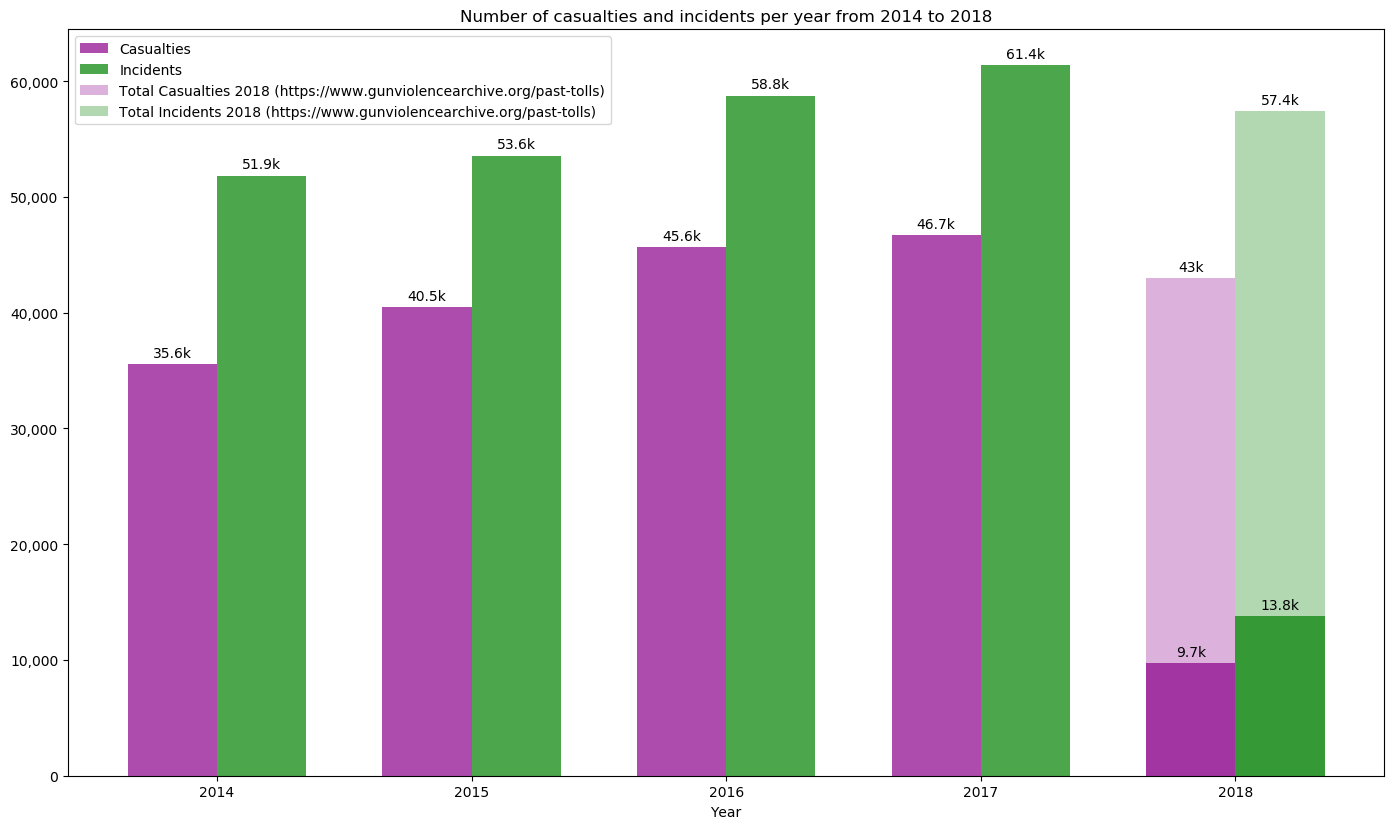

In [604]:
fig, ax = plt.subplots(figsize=(14, 8))

bar_width = 0.35
bars1 = ax.bar(np.arange(len(casualties_by_year)) - bar_width/2, [0, 0, 0, 0, 43008], bar_width, alpha=0.3, label='Total Casualties 2018 (https://www.gunviolencearchive.org/past-tolls)', align='center', color='darkmagenta')
bars2 = ax.bar(np.arange(len(incidents_by_year)) + bar_width/2, [0, 0, 0, 0, 57386], bar_width, alpha=0.3, label='Total Incidents 2018 (https://www.gunviolencearchive.org/past-tolls)', align='center', color='green')
bars3 = ax.bar(np.arange(len(casualties_by_year)) - bar_width/2, list(casualties_by_year.values()), bar_width, alpha=0.7, label='Casualties', align='center', color='darkmagenta')
bars4 = ax.bar(np.arange(len(incidents_by_year)) + bar_width/2, list(incidents_by_year.values()), bar_width, alpha=0.7, label='Incidents', align='center', color='green')

plt.xticks(range(len(casualties_by_year)), list(casualties_by_year.keys()))

handles, labels = ax.get_legend_handles_labels()

# Change order of items in the legend
handles = [handles[2], handles[3], handles[0], handles[1]]
labels = [labels[2], labels[3], labels[0], labels[1]]
plt.legend(handles, labels, loc='upper left')

# Function to provide number represented by the bars on top
def toplabel(bars):
    for bar in bars:
        height = bar.get_height()
        if height != 0:
            if int(height/100) % 10 == 0:
                ax.annotate("{}k".format(int(height / 1000)), xy=(bar.get_x() + bar.get_width()/2, height), 
                            xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
            else:
                ax.annotate("{:.1f}k".format(height / 1000), xy=(bar.get_x() + bar.get_width()/2, height), 
                            xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

toplabel(bars1)
toplabel(bars2)
toplabel(bars3)
toplabel(bars4)

fig.tight_layout()
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel("Year")
plt.title("Number of casualties and incidents per year from 2014 to 2018")
plt.show()

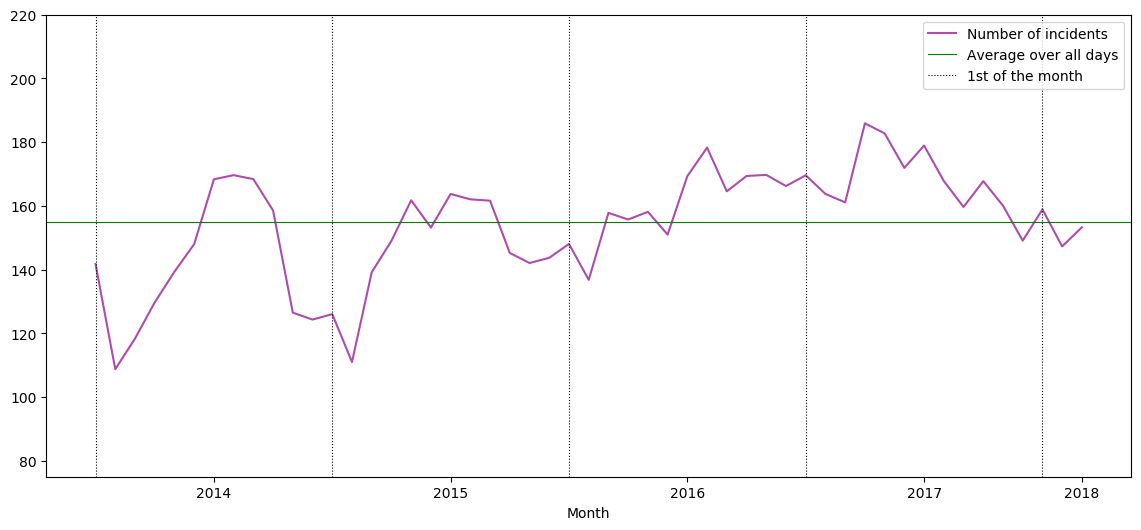

In [627]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(list(incidents_by_month.keys()), list(incidents_by_month.values()), label='Number of incidents', alpha=0.7, color='darkmagenta')
ax.axhline(sum(incidents_by_date_mean.values()) / 366, label='Average over all days', color='green', linestyle='-', linewidth=0.8)

ax.set_xlabel("Month")

ax.set_ylim([75, 220])

plt.setp(ax, xticks=['2014_7', '2015_7', '2016_7', '2017_7', '2018_3'], xticklabels=['2014', '2015', '2016', '2017', '2018'])
for year in range(2014, 2019):
    mline = ax.axvline(str(year) + '_1', color='black', linestyle=':', linewidth=0.8)
mline.set_label('1st of the month')
plt.legend(loc='upper right')
plt.show()

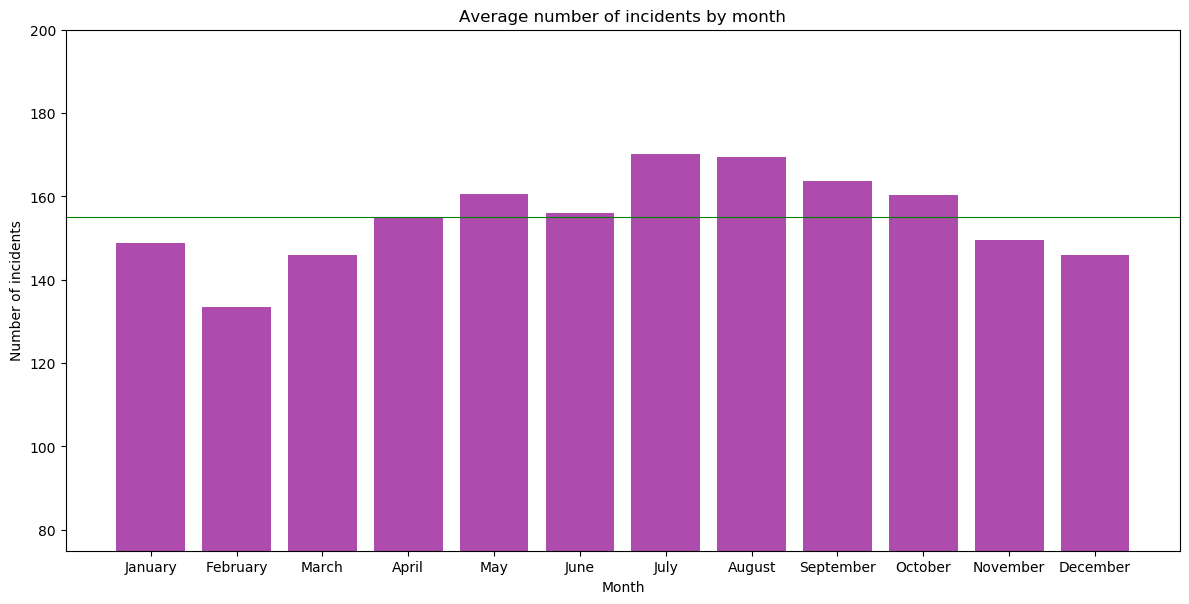

In [610]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(np.arange(12), list(incidents_by_month_2.values()), label='Incidents', align='center', alpha=0.7, color='darkmagenta')
ax.axhline(sum(incidents_by_date_mean.values()) / 366, color='green', linestyle='-', linewidth=0.8)

ax.set_ylabel("Number of incidents")
ax.set_xlabel("Month")

ax.set_ylim([75, 200])

fig.tight_layout()

plt.xticks(range(len(incidents_by_month_2)), map(lambda x: calendar.month_name[x], incidents_by_month_2.keys()))

plt.title("Average number of incidents by month")
plt.show()

In [452]:
df = pd.DataFrame(incidents_by_month)

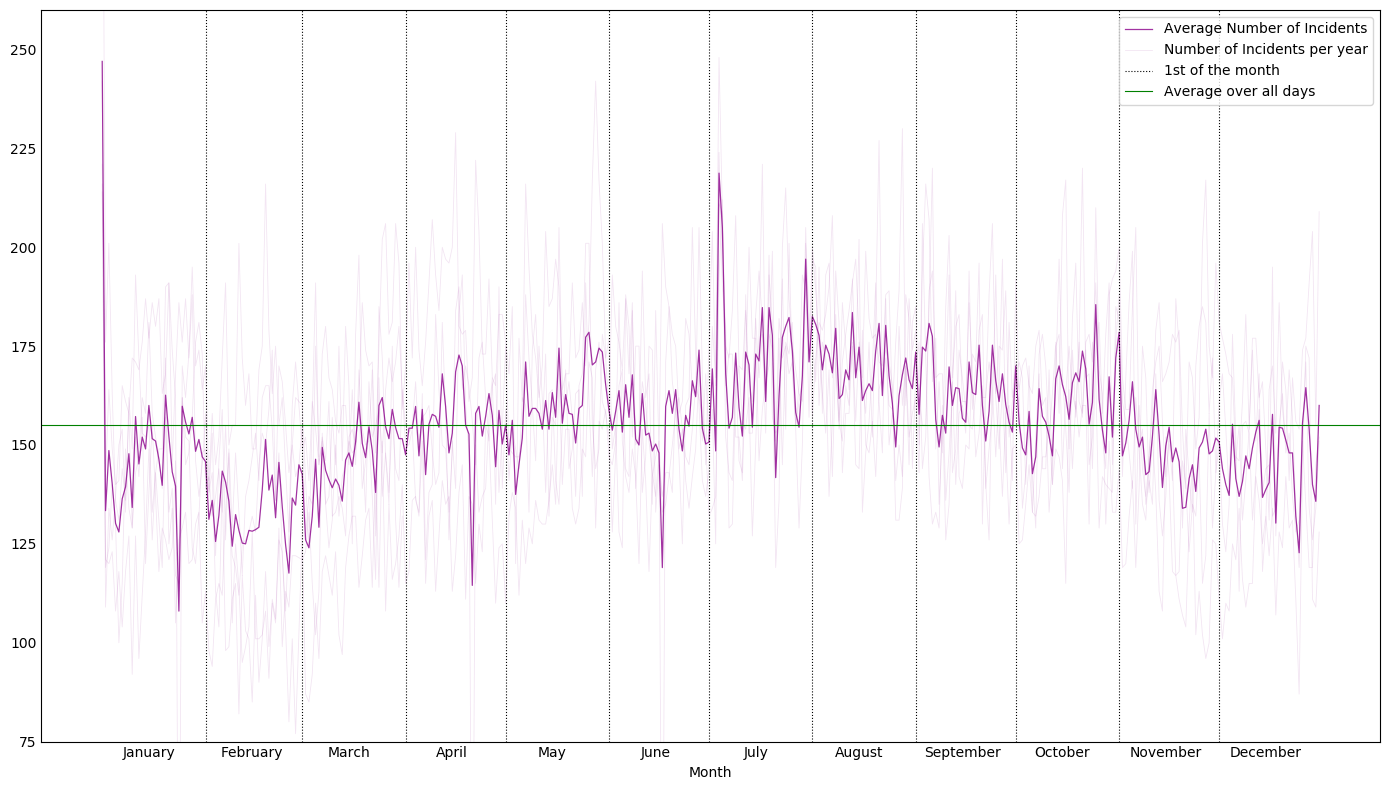

In [613]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(list(key for key in incidents_by_date_mean.keys()), list(incidents_by_date_mean.values()), label='Average Number of Incidents', alpha=0.8, color='darkmagenta', linewidth=0.9)
for year in range(2014, 2019):
    line, = ax.plot(list(key.replace(year=2000) for key in incidents_by_date.keys() if key.year == year), 
              list(value for (key, value) in incidents_by_date.items() if key.year == year), alpha=0.1, color='darkmagenta', linewidth=0.6)
line.set_label('Number of Incidents per year')

ax.set_ylim([75, 260])
ax.set_xlabel("Month")
plt.setp(ax, xticks=[dt(2000, 1, 15), dt(2000, 2, 15), dt(2000, 3, 15), dt(2000, 4, 15), dt(2000, 5, 15), 
                     dt(2000, 6, 15), dt(2000, 7, 15), dt(2000, 8, 15), dt(2000, 9, 15), dt(2000, 10, 15), 
                     dt(2000, 11, 15), dt(2000, 12, 15)], xticklabels=months)
for month in range(2, 13):
    mline = ax.axvline(dt(2000, month, 1), color='black', linestyle=':', linewidth=0.8)
ax.axhline(sum(incidents_by_date_mean.values()) / 366, label='Average over all days', color='green', linestyle='-', linewidth=0.8)
mline.set_label('1st of the month')
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.legend(loc='upper right')
fig.tight_layout()
plt.show()

In [614]:
incidents_count = Counter(incidents_by_date)
print("The dates with the most incidends between January 2014 and March 2018:")
for k, v in incidents_count.most_common(10):
    print('   --  %i %s %i: \t%i incidents' % (k.day, calendar.month_name[k.month], k.year, v))

The dates with the most incidends between January 2014 and March 2018:
   --  1 January 2017: 	342 incidents
   --  4 July 2017: 	248 incidents
   --  28 May 2017: 	242 incidents
   --  1 January 2018: 	242 incidents
   --  28 August 2016: 	230 incidents
   --  16 April 2017: 	229 incidents
   --  21 August 2016: 	227 incidents
   --  4 July 2016: 	224 incidents
   --  22 April 2017: 	222 incidents
   --  1 January 2016: 	221 incidents


In [615]:
incidents_count_mean = Counter(incidents_by_date_mean)
print("The dates with the most incidends every year:")
for k, v in incidents_count.most_common(10):
    print('   --  %i %s:  \t%i incidents' % (k.day, calendar.month_name[k.month], v))

The dates with the most incidends every year:
   --  1 January:  	342 incidents
   --  4 July:  	248 incidents
   --  28 May:  	242 incidents
   --  1 January:  	242 incidents
   --  28 August:  	230 incidents
   --  16 April:  	229 incidents
   --  21 August:  	227 incidents
   --  4 July:  	224 incidents
   --  22 April:  	222 incidents
   --  1 January:  	221 incidents


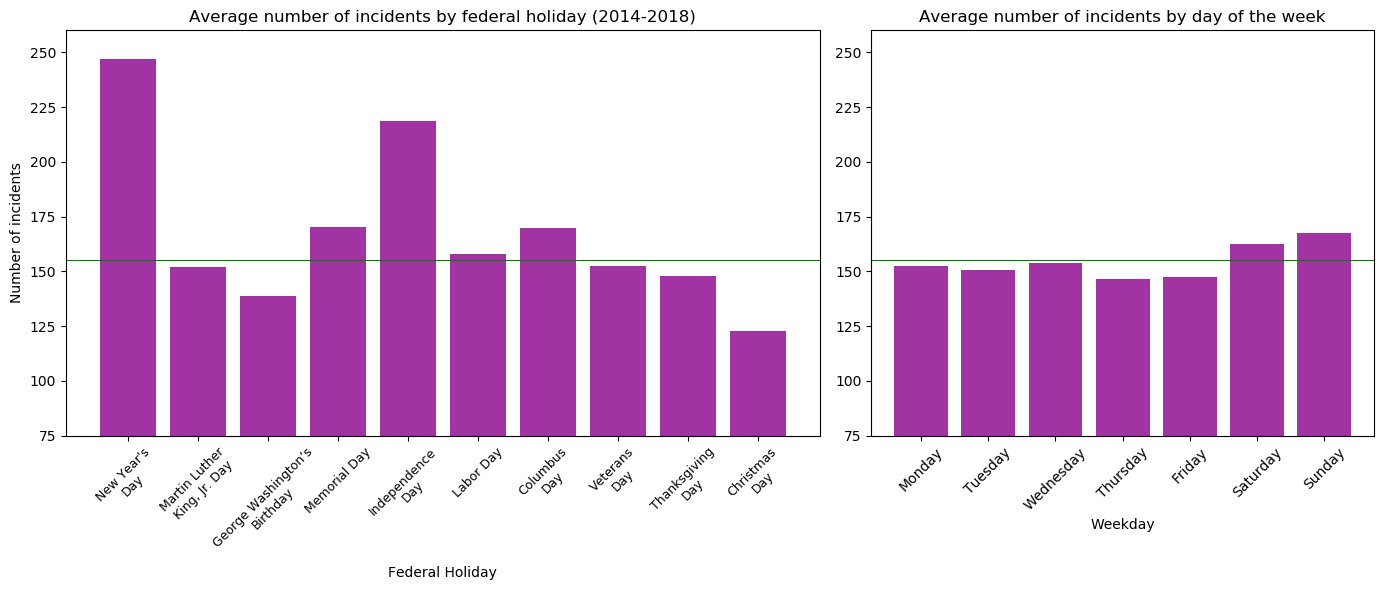

In [616]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1.5, 1]})

ax[0].bar(np.arange(len(holidays)), [incidents_count_mean[v] for k, v in holidays.items()], label='Incidents', align='center', alpha=0.8, color='darkmagenta')
ax[1].bar(np.arange(len(weekdays)), list(incidents_by_weekday.values()), label='Incidents', align='center', alpha=0.8, color='darkmagenta')
ax[0].axhline(sum(incidents_by_date_mean.values()) / 366, color='green', linestyle='-', linewidth=0.8)
ax[1].axhline(sum(incidents_by_date_mean.values()) / 366, color='green', linestyle='-', linewidth=0.8)

ax[0].set_ylabel("Number of incidents")

ax[0].set_xlabel("Federal Holiday")
ax[1].set_xlabel("Weekday")

ax[0].set_title("Average number of incidents by federal holiday (2014-2018)")
ax[1].set_title("Average number of incidents by day of the week")

ax[0].set_ylim([75, 260])
ax[1].set_ylim([75, 260])

plt.sca(ax[0])
plt.xticks(range(0, len(holidays)), ["New Year's\nDay", 'Martin Luther\nKing, Jr. Day', 'George Washington’s\nBirthday', 'Memorial Day', 'Independence\nDay', 'Labor Day', 'Columbus\nDay', 'Veterans\nDay', 'Thanksgiving\nDay', 'Christmas\nDay'], rotation=45, fontsize = 9)
plt.sca(ax[1])
plt.xticks(range(0, 7), weekdays, rotation=45)

fig.tight_layout()
plt.show()

## State

In [648]:
#Hack to fix missing PROJ4 env var
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.patches import Polygon
from matplotlib.colorbar import ColorbarBase

In [640]:
states = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado",
              "Connecticut", "District of Columbia", "Delaware", "Florida", "Georgia", 
              "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", 
              "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", 
              "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", 
              "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania",
              "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah",
              "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]
state_abbreviations = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
                      "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
                      "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
                      "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
                      "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
state_population = {'Alabama': 4853193, 'Alaska': 738438, 'Arizona': 6839353, 'Arkansas': 2979818, 
                    'California': 38893516, 'Colorado': 5446126, 'Connecticut': 3585952, 
                    'District of Columbia': 940788, 'Delaware': 674093, 'Florida': 20250908, 
                    'Georgia': 10188251, 'Hawaii': 1419621, 'Idaho': 1659273, 'Illinois': 12852933,
                    'Indiana': 6612724, 'Iowa': 3119893, 'Kansas': 2905172, 'Kentucky': 4427480, 
                    'Louisiana': 4656533, 'Maine': 1330774, 'Maryland': 5979634, 'Massachusetts': 6792551,
                    'Michigan': 9940970, 'Minnesota': 5487856, 'Mississippi': 2989215, 'Missouri': 6072902,
                    'Montana': 1031982, 'Nebraska': 1891988, 'Nevada': 2871365, 'New Hampshire': 1337613, 
                    'New Jersey': 8871814, 'New Mexico': 2091906, 'New York': 19635618, 
                    'North Carolina': 10047620, 'North Dakota': 744586, 'Ohio': 11619306, 
                    'Oklahoma': 3900162, 'Oregon': 4028386, 'Pennsylvania': 12785093, 
                    'Rhode Island': 1056172, 'South Carolina': 4891931, 'South Dakota': 856293, 
                    'Tennessee': 6595774, 'Texas': 27442726, 'Utah': 2992711, 'Vermont': 624959, 
                    'Virginia': 8360838, 'Washington': 7179800, 'West Virginia': 1838663, 
                    'Wisconsin': 5763068, 'Wyoming': 582713}

In [641]:
# Map plotting constants
AREA_1 = 0.005  # exclude small Hawaiian islands that are smaller than AREA_1
AREA_2 = AREA_1 * 30.0  # exclude Alaskan islands that are smaller than AREA_2
AK_SCALE = 0.19  # scale down Alaska to show as a map inset
HI_OFFSET_X = -1900000  # X coordinate offset amount to move Hawaii "beneath" Texas
HI_OFFSET_Y = 250000    # similar to above: Y offset for Hawaii
AK_OFFSET_X = -250000   # X offset for Alaska (These four values are obtained
AK_OFFSET_Y = -750000   # via manual trial and error, thus changing them is not recommended.)

# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
# Mercator projection, for Alaska and Hawaii
m_ = Basemap(llcrnrlon=-190,llcrnrlat=20,urcrnrlon=-143,urcrnrlat=46,
            projection='merc',lat_ts=20)

In [642]:
nr_casualties_per_state = dict((state, 0) for state in states)
nr_incidents_per_state = dict((state, 0) for state in states)

for row in data.values:
    nr_casualties_per_state[row[data.columns.get_loc('State')]] += row[data.columns.get_loc('Nr Killed')] + row[data.columns.get_loc("Nr Injured")]
    nr_incidents_per_state[row[data.columns.get_loc('State')]] += 1
    
nr_casualties_per_capita = {state: round(nr_casualties_per_state[state]*100000/state_population[state], 1) for state in nr_casualties_per_state}
nr_incidents_per_capita = {state: round(nr_incidents_per_state[state]*100000/state_population[state], 1) for state in nr_incidents_per_state}

In [673]:
def plot_map(values, vmin, vmax, title, legend_label):
    fig, ax = plt.subplots(figsize=(15, 10))

    #%% ---------   draw state boundaries  ----------------------------------------
    ## data from U.S Census Bureau
    ## http://www.census.gov/geo/www/cob/st2000.html
    shp_info = m.readshapefile('st99_d00','states',drawbounds=True,
                               linewidth=0.45,color='gray')
    shp_info_ = m_.readshapefile('st99_d00','states',drawbounds=False)

    #%% -------- choose a color for each state based on population density. -------
    colors={}
    statenames=[]
    cmap = plt.cm.PRGn_r
    norm = Normalize(vmin=vmin, vmax=vmax)
    for shapedict in m.states_info:
        statename = shapedict['NAME']
        if statename not in ['District of Columbia','Puerto Rico']:
            ncpc = values[statename]
            colors[statename] = cmap(np.sqrt((ncpc-vmin)/(vmax-vmin)))[:3]
        statenames.append(statename)

    #%% ---------  cycle through state names, color each one.  --------------------
    for nshape, seg in enumerate(m.states):
        # skip DC and Puerto Rico.
        if statenames[nshape] not in ['Puerto Rico', 'District of Columbia']:
            color = rgb2hex(colors[statenames[nshape]])
            poly = Polygon(seg, facecolor=color, edgecolor=color)
            ax.add_patch(poly)

    for nshape, shapedict in enumerate(m_.states_info):  # plot Alaska and Hawaii as map insets
        if shapedict['NAME'] in ['Alaska', 'Hawaii']:
            seg = m_.states[int(shapedict['SHAPENUM'] - 1)]
            if shapedict['NAME'] == 'Hawaii' and float(shapedict['AREA']) > AREA_1:
                seg = [(x + HI_OFFSET_X, y + HI_OFFSET_Y) for x, y in seg]
                color = rgb2hex(colors[statenames[nshape]])
            elif shapedict['NAME'] == 'Alaska' and float(shapedict['AREA']) > AREA_2:
                seg = [(x*AK_SCALE + AK_OFFSET_X, y*AK_SCALE + AK_OFFSET_Y)\
                       for x, y in seg]
                color = rgb2hex(colors[statenames[nshape]])
            poly = Polygon(seg, facecolor=color, edgecolor='gray', linewidth=.45)
            ax.add_patch(poly)
            
    #%% ---------  Plot bounding boxes for Alaska and Hawaii insets  --------------
    light_gray = [0.8]*3  # define light gray color RGB
    x1,y1 = m_([-190,-183,-180,-180,-175,-171,-171],[29,29,26,26,26,22,20])
    x2,y2 = m_([-180,-180,-177],[26,23,20])  # these numbers are fine-tuned manually
    m_.plot(x1,y1,color=light_gray,linewidth=0.8)  # do not change them drastically
    m_.plot(x2,y2,color=light_gray,linewidth=0.8)

    ###---------------------------------------------------------------------------

    ax.set_title(title)

    # Colour bar
    ax_c = fig.add_axes([0.92, 0.1, 0.03, 0.8])
    cb = ColorbarBase(ax_c,cmap=cmap,norm=norm,orientation='vertical',
                      label=legend_label)

    plt.show()

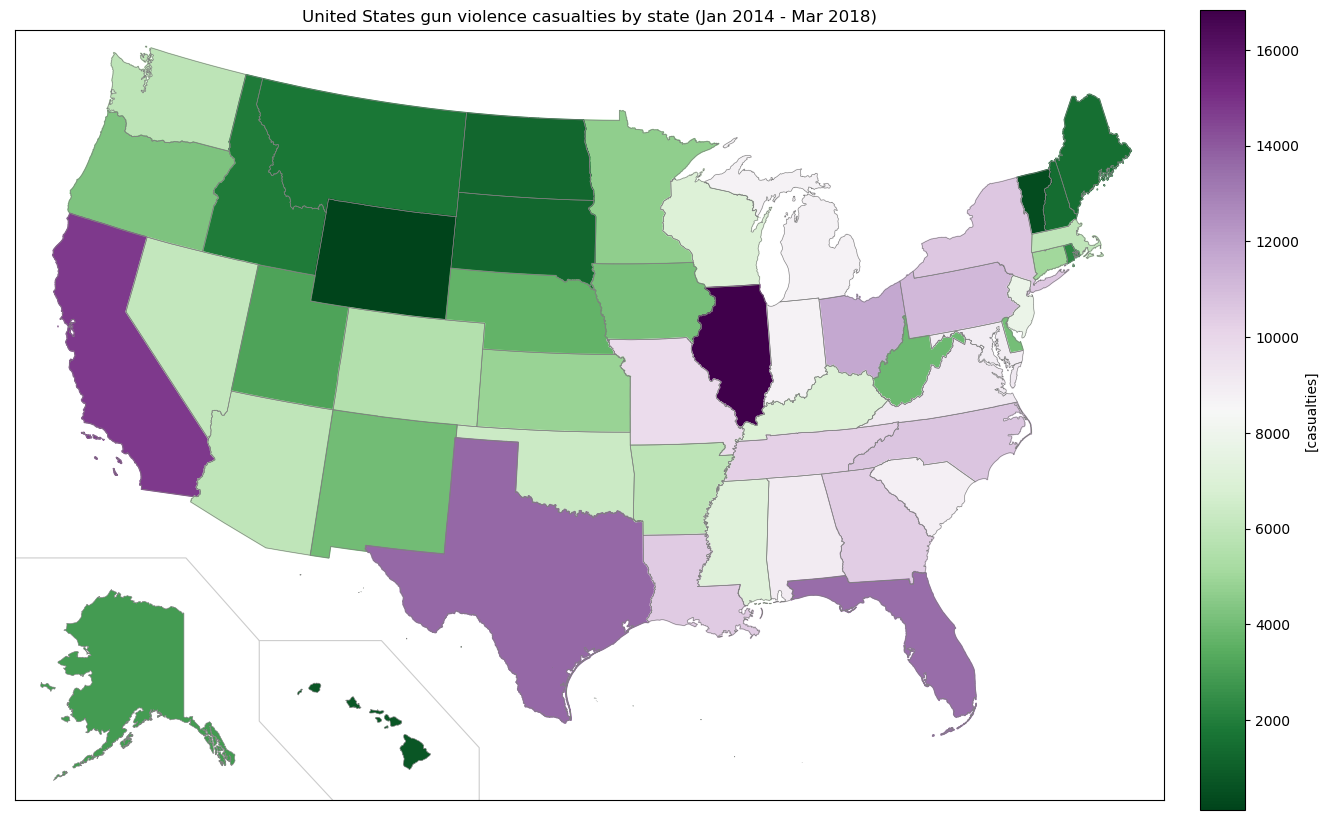

In [675]:
plot_map(nr_casualties_per_state, min(nr_casualties_per_state.values()), max(nr_casualties_per_state.values()), 'United States gun violence casualties by state (Jan 2014 - Mar 2018)', '[casualties]')

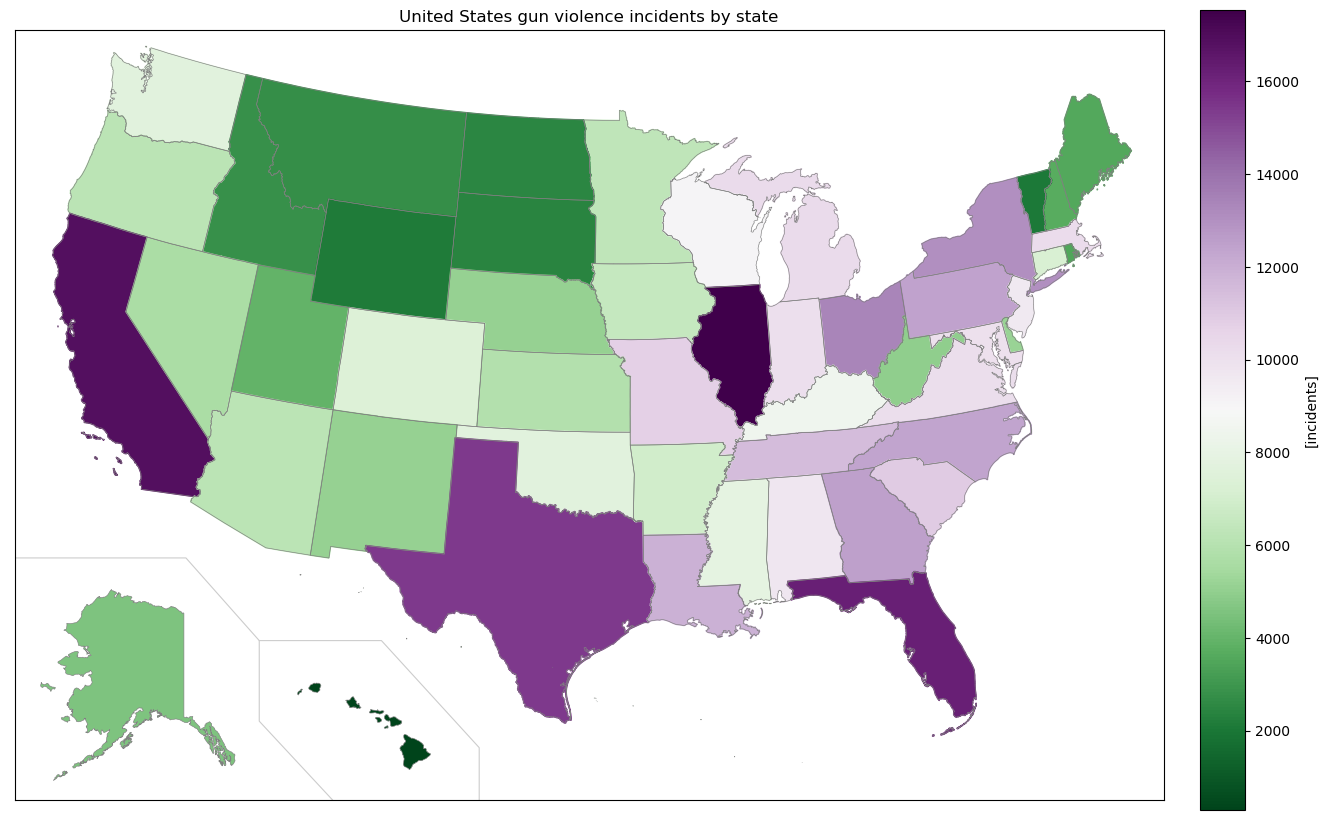

In [679]:
plot_map(nr_incidents_per_state, min(nr_incidents_per_state.values()), max(nr_incidents_per_state.values()), 'United States gun violence incidents by state', '[incidents]')

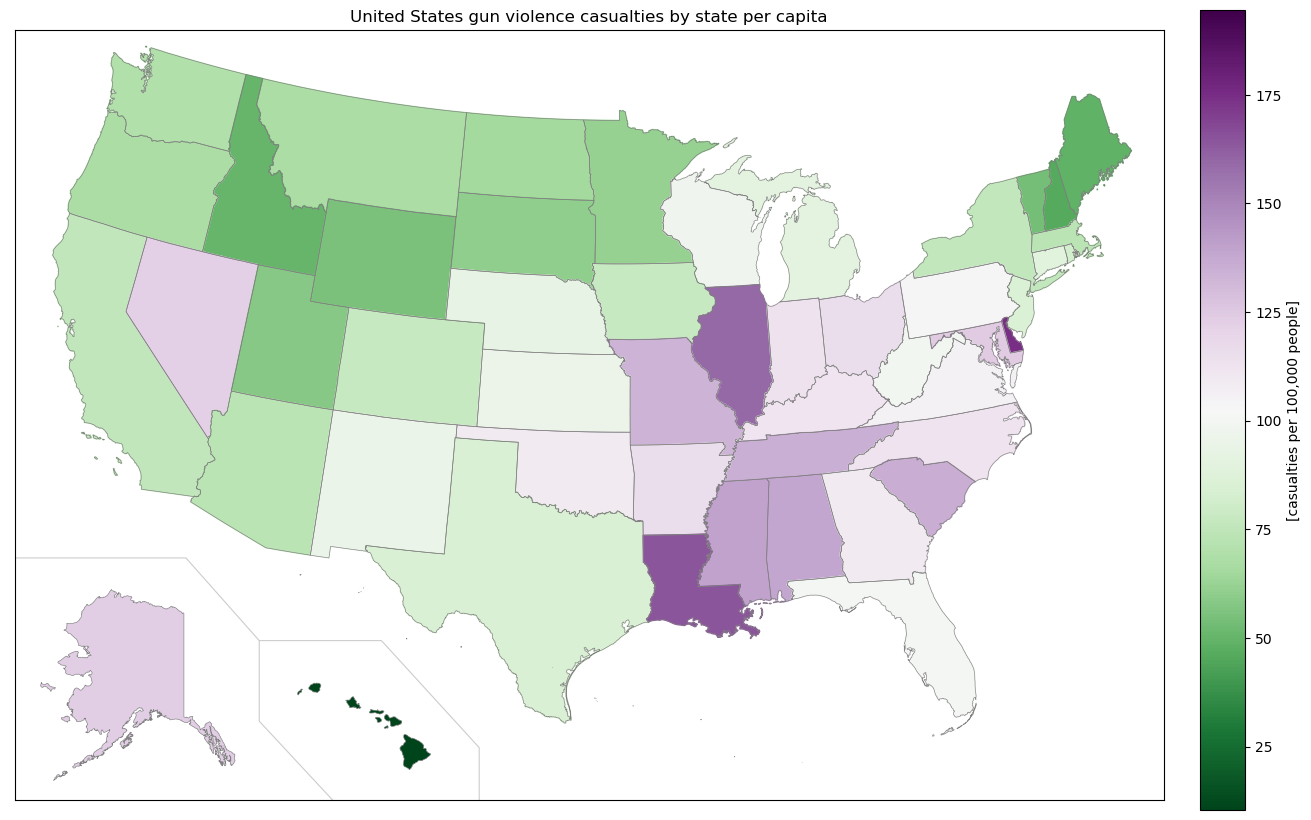

In [677]:
plot_map(nr_casualties_per_capita, min(nr_casualties_per_capita.values()), max(nr_casualties_per_capita.values()), 'United States gun violence casualties by state per capita', '[casualties per 100,000 people]')

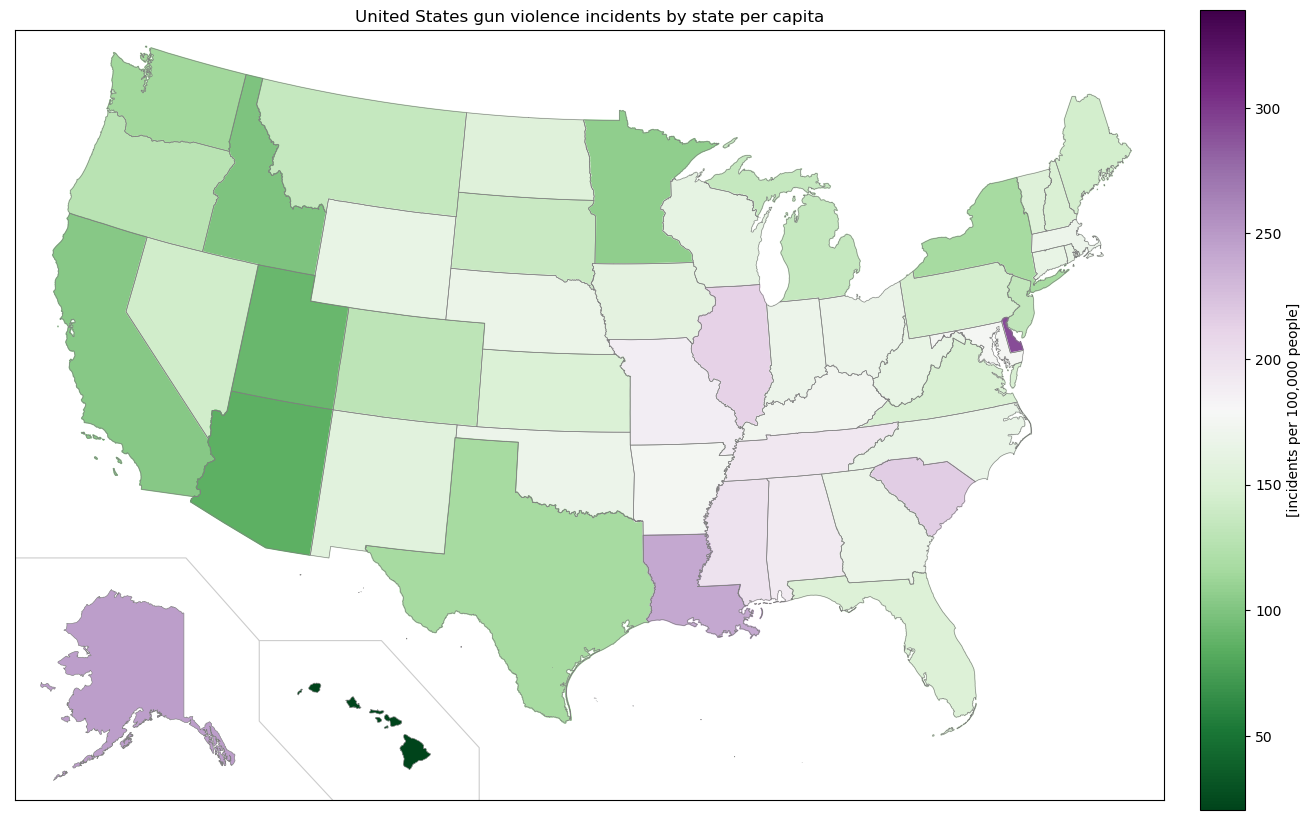

In [678]:
plot_map(nr_incidents_per_capita, min(nr_incidents_per_capita.values()), max(nr_incidents_per_capita.values()), 'United States gun violence incidents by state per capita', '[incidents per 100,000 people]')

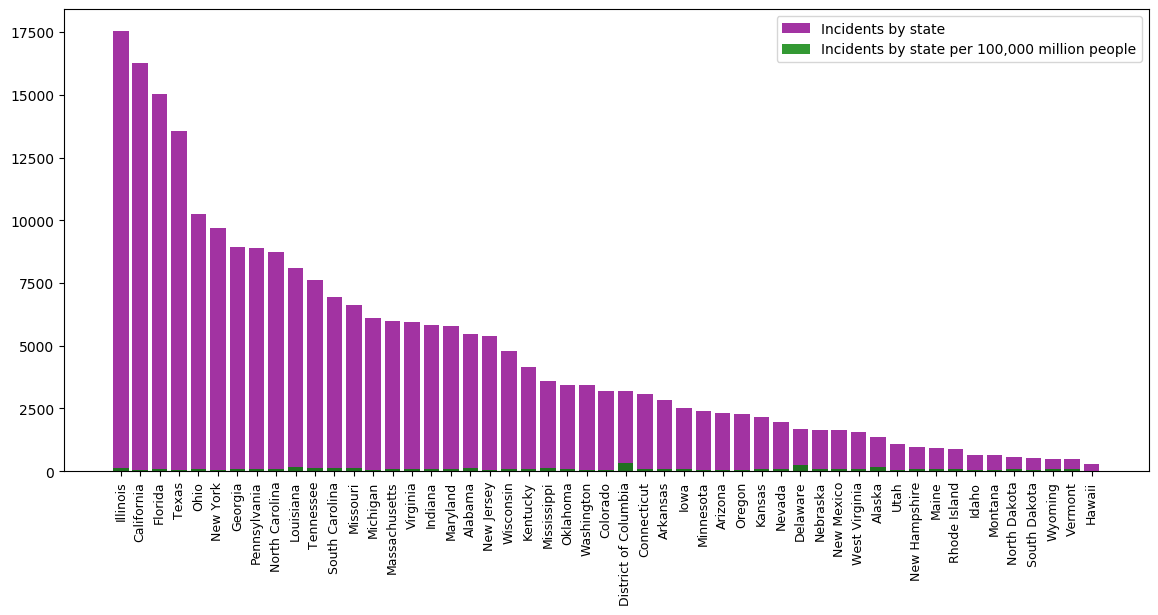

In [724]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.bar(dict(sorted(nr_incidents_per_state.items(), key=lambda kv: kv[1], reverse=True)).keys(), dict(sorted(nr_incidents_per_state.items(), key=lambda kv: kv[1], reverse=True)).values(), label="Incidents by state", alpha=0.8, color="darkmagenta")
ax.bar(dict(sorted(nr_incidents_per_capita.items(), key=lambda kv: kv[1], reverse=True)).keys(), dict(sorted(nr_incidents_per_capita.items(), key=lambda kv: kv[1], reverse=True)).values(), label="Incidents by state per 100,000 million people", alpha=0.8, color="green")

plt.xticks(rotation=90, fontsize = 9)
plt.legend(loc='upper right')
plt.show()

## Cities